In [3]:
# === Import Core Libraries ===
import pandas as pd                         # For data manipulation and analysis
import numpy as np                          # For numerical operations and array handling
import matplotlib.pyplot as plt             # For basic plotting and data visualization
import seaborn as sns                       # For advanced statistical plotting and aesthetics
import warnings                            # To control warning messages

In [4]:
# === Scikit-learn Modules for Preprocessing and Modeling ===
from sklearn.model_selection import train_test_split     # For splitting data into training and test sets
from sklearn.preprocessing import StandardScaler         # For feature scaling/standardization
from sklearn.ensemble import RandomForestClassifier      # Random Forest model
from sklearn.linear_model import LogisticRegression      # Logistic Regression model

# === Scikit-learn Modules for Evaluation ===
from sklearn.metrics import (
    classification_report,                  # For detailed classification performance metrics
    confusion_matrix,                       # For computing the confusion matrix
    roc_auc_score,                          # For calculating the Area Under the ROC Curve (AUC)
    roc_curve,                              # For generating ROC curve data
    ConfusionMatrixDisplay                  # For visualizing confusion matrices
)

# === External Libraries ===
from xgboost import XGBClassifier           # XGBoost model for high-performance gradient boosting
from imblearn.over_sampling import SMOTE    # Synthetic Minority Oversampling Technique for handling class imbalance
import shap                                 # SHAP for model explainability and interpretation

# === Suppress Warnings ===
warnings.filterwarnings("ignore")           # Suppresses warnings to keep output clean (use with caution)

In [5]:
# === Load Dataset ===
# Read the AI4I 2020 Predictive Maintenance dataset into a pandas DataFrame
df = pd.read_csv("ai4i2020.csv")

# Preview the first five rows to verify successful loading and inspect initial structure
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
# === Dataset Overview ===

# Display concise summary of the DataFrame, including
# data types, non-null counts, and memory usage.
df.info()

# === Descriptive Statistics ===

# Generate summary statistics for numerical features:
# count, mean, std deviation, min, quartiles, and max.
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [7]:
# === Drop Unnecessary Columns ===
# 'UDI' is a unique identifier and 'Product ID' is non-informative for prediction, so both are removed.
df.drop('UDI', axis=1, inplace=True)
df.drop('Product ID', axis=1, inplace=True)

# === Column Name Cleanup ===
# Replace spaces with underscores to improve code readability and compatibility
df.columns = df.columns.str.replace(' ', '_')

# === Feature Engineering ===

# Create a new feature: temperature delta between process and air temperature
df['Temp_Delta'] = df['Process_temperature_[K]'] - df['Air_temperature_[K]']

# Calculate mechanical power in Watts:
# Power = Torque (Nm) × Angular Velocity (rad/s)
df['Power_[W]'] = df['Torque_[Nm]'] * (df['Rotational_speed_[rpm]'] * 2 * np.pi / 60)

# Create a normalized tool wear feature relative to torque
df['Wear_per_Torque'] = df['Tool_wear_[min]'] / (df['Torque_[Nm]'] + 1e-5)

# Create a speed-to-torque ratio to capture drivetrain stress relationships
df['Speed_Torque_Ratio'] = df['Rotational_speed_[rpm]'] / (df['Torque_[Nm]'] + 1e-5)

# === One-Hot Encoding ===
# Convert categorical 'Type' variable into binary dummy variables (Type_H, Type_M, Type_L)
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

# Preview the updated DataFrame with engineered features
df.head()

,Air_temperature_[K],Process_temperature_[K],Rotational_speed_[rpm],Torque_[Nm],Tool_wear_[min],Machine_failure,TWF,HDF,PWF,OSF,RNF,Temp_Delta,Power_[W],Wear_per_Torque,Speed_Torque_Ratio,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.590560,0.000000,36.238309,False,False,True
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.722724,0.064795,30.410361,False,True,False
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.387543,0.101215,30.323881,False,True,False
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.504659,0.177215,36.278472,False,True,False
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.816608,0.225000,35.199991,False,True,False


In [8]:
# === Define Features for Visualization ===
# Select key numeric and engineered features to include in EDA plots (e.g., boxplots, histograms, violin plots)
features_to_plot = [
    'Air_temperature_[K]', 
    'Process_temperature_[K]', 
    'Rotational_speed_[rpm]', 
    'Torque_[Nm]', 
    'Tool_wear_[min]', 
    'Temp_Delta', 
    'Power_[W]',
    'Wear_per_Torque',
    'Speed_Torque_Ratio'
]

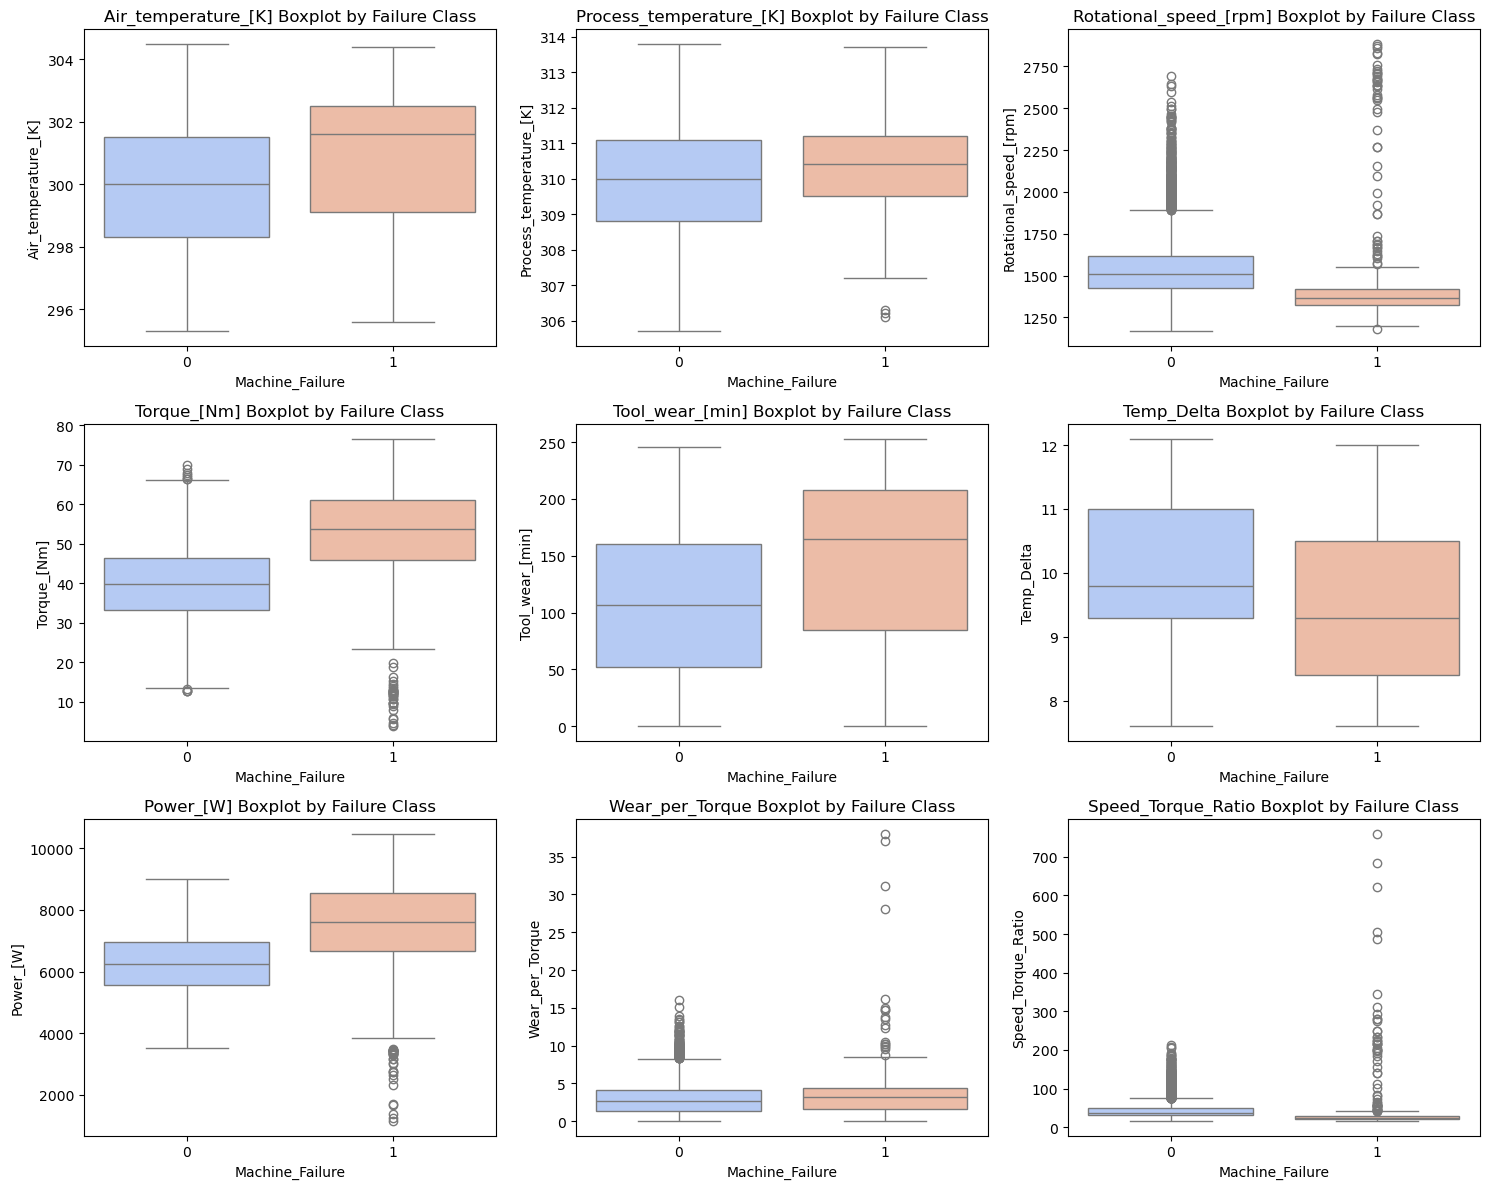

In [9]:
# === Boxplots of Key Features by Failure Class ===
# Visualize the distribution and spread of each selected feature, grouped by machine failure status.
# This helps identify outliers and differences in feature behavior between failure and non-failure cases.

plt.figure(figsize=(15, 12))  # Set overall figure size

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
    sns.boxplot(data=df, x='Machine_failure', y=feature, palette='coolwarm')  # Plot boxplot by failure class
    plt.title(f"{feature} Boxplot by Failure Class")  # Set plot title
    plt.xlabel("Machine_Failure")  # Label x-axis
    plt.ylabel(feature)  # Label y-axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

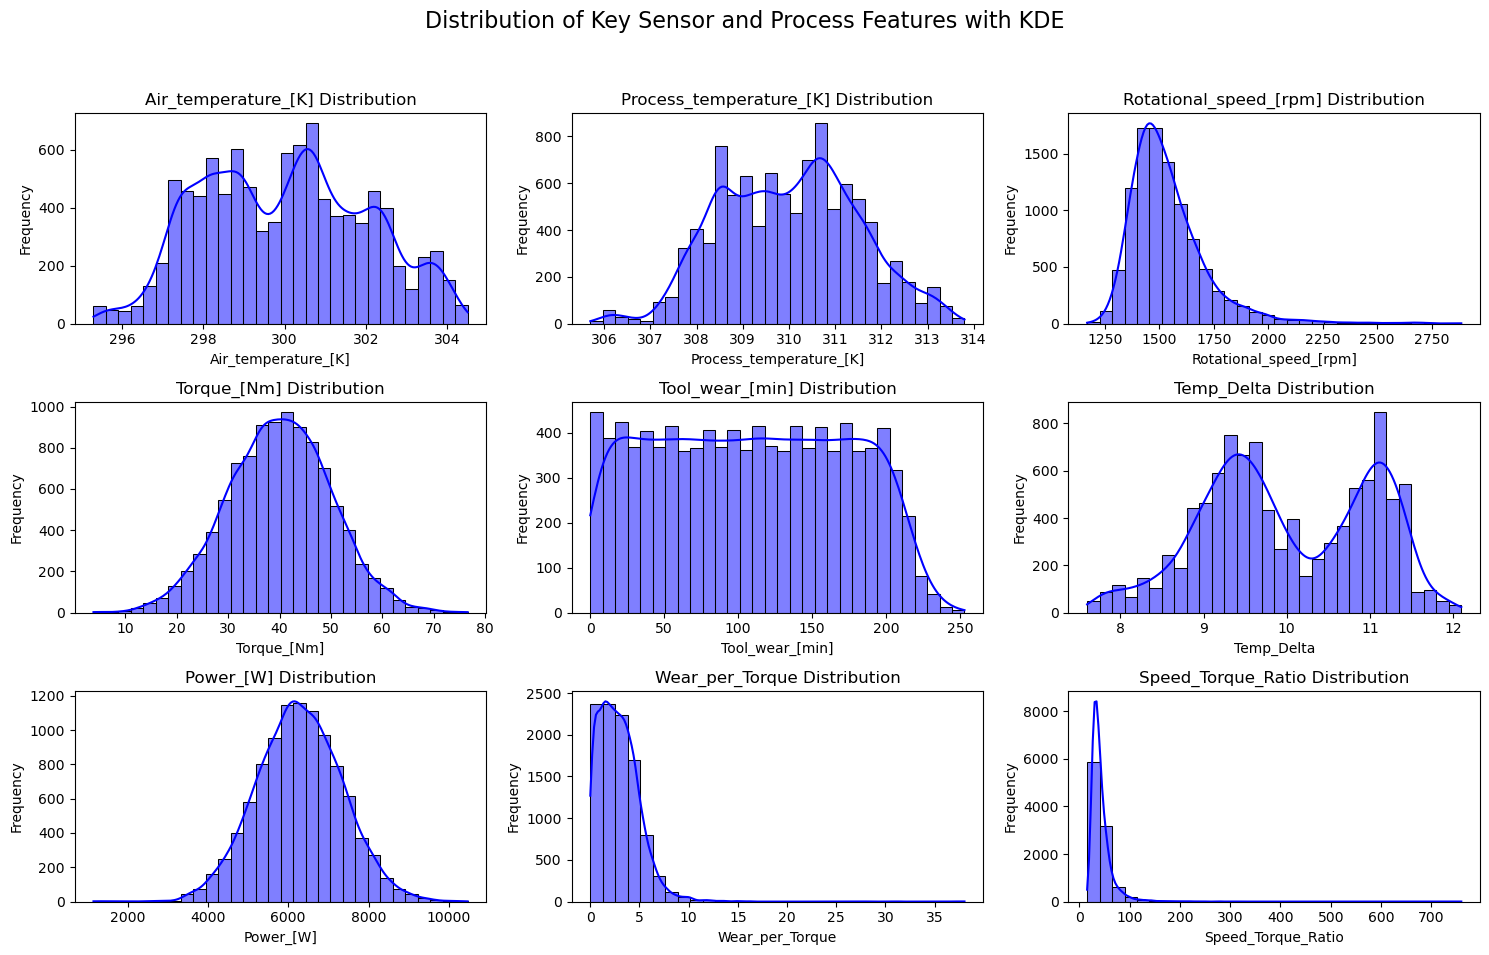

In [10]:
# === Feature Distribution Histograms ===
# Plot histograms with KDE overlays to examine the distribution of each feature.
# Helps assess normality, skewness, and potential transformation needs.

plt.figure(figsize=(15, 10))  # Set overall figure size

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
    sns.histplot(df[feature], kde=True, bins=30, color='blue')  # Plot histogram with KDE curve
    plt.title(f"{feature} Distribution")  # Set subplot title
    plt.xlabel(feature)  # Label x-axis
    plt.ylabel("Frequency")  # Label y-axis

# Set a shared super-title for the entire figure
plt.suptitle("Distribution of Key Sensor and Process Features with KDE", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle
plt.show()  # Display the full grid of histograms

Machine_failure
0    9661
1     339
Name: count, dtype: int64


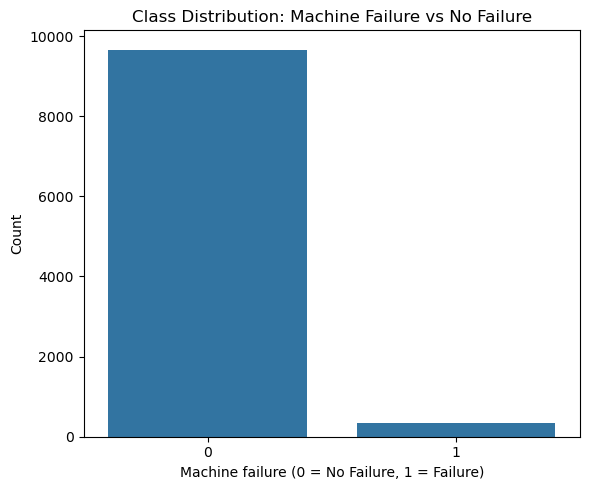

In [11]:
# === Class Distribution Analysis ===
# Print the number of samples in each class (0 = No Failure, 1 = Failure)
# Useful for identifying potential class imbalance issues
print(df['Machine_failure'].value_counts())

# Plot the distribution of the target variable (Machine_failure)
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Machine_failure')  # Count plot for target class
plt.title("Class Distribution: Machine Failure vs No Failure")  # Set plot title
plt.xlabel("Machine failure (0 = No Failure, 1 = Failure)")  # Label x-axis
plt.ylabel("Count")  # Label y-axis
plt.tight_layout()  # Prevent clipping
plt.show()  # Display the plot

TWF     46
HDF    115
PWF     95
OSF     98
RNF      1
dtype: int64


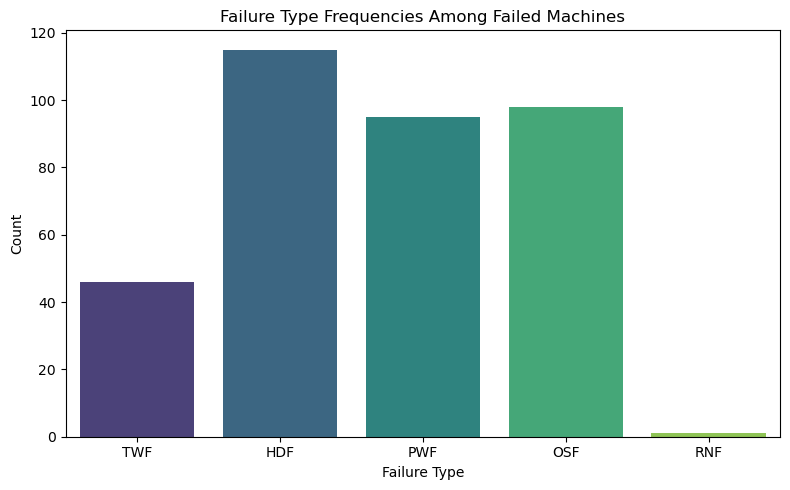

In [12]:
# === Failure Type Distribution Among Failed Machines ===

# Define the five types of failures present in the dataset
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Filter dataset to include only machines that experienced failure
df_failures = df[df['Machine_failure'] == 1]

# Count how many times each failure type occurred
failure_counts = df_failures[failure_types].sum()

# Print the raw counts for reference
print(failure_counts)

# Plot a bar chart to visualize the frequency of each failure type
plt.figure(figsize=(8, 5))
sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='viridis')
plt.title("Failure Type Frequencies Among Failed Machines")
plt.ylabel("Count")
plt.xlabel("Failure Type")
plt.tight_layout()
plt.show()

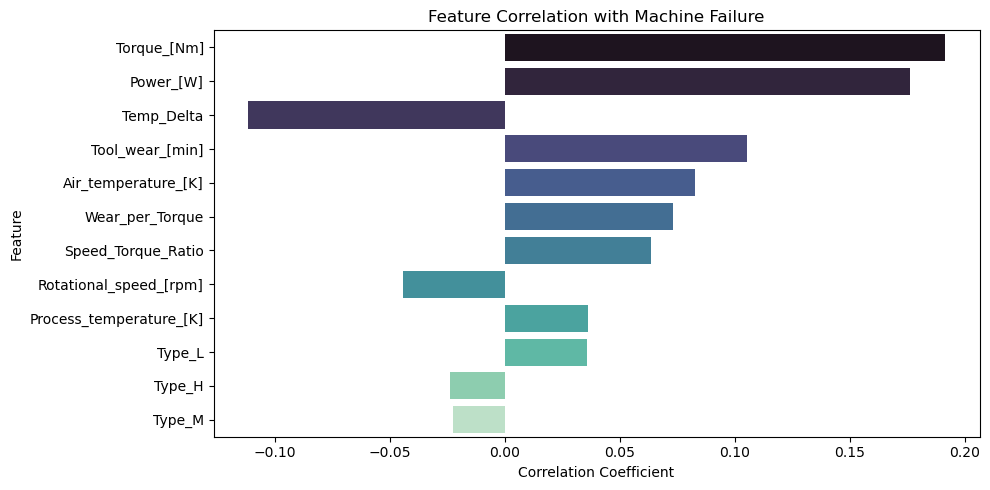

In [13]:
# === Feature Correlation with Target Variable ===
# Compute Pearson correlation of all features with the binary target 'Machine_failure'
# Drop the target itself and individual failure type flags to focus on meaningful predictors
correlations = df.corr()['Machine_failure'].drop(['Machine_failure', 'OSF', 'HDF', 'PWF', 'TWF', 'RNF']).sort_values(key=abs, ascending=False)

# Plot a horizontal bar chart of absolute correlation values
plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette="mako")
plt.title("Feature Correlation with Machine Failure")  # Set plot title
plt.xlabel("Correlation Coefficient")  # Label x-axis
plt.ylabel("Feature")  # Label y-axis
plt.tight_layout()
plt.show()

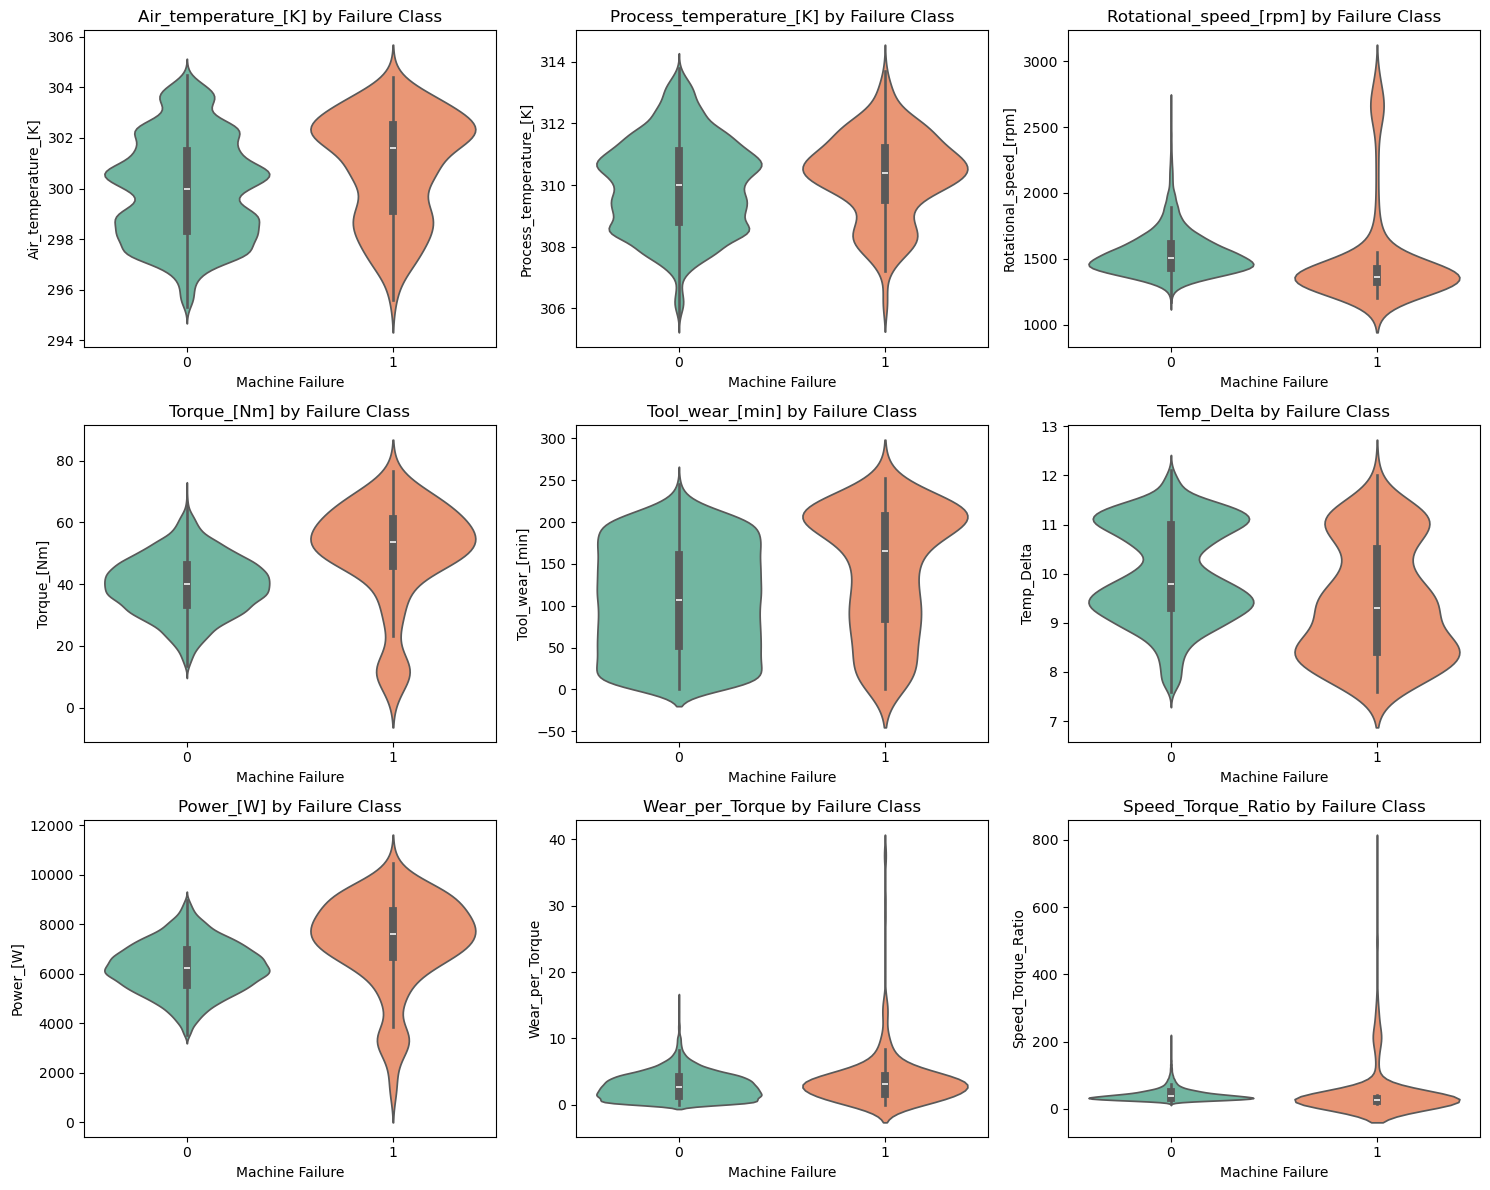

In [14]:
# === Violin Plots of Features by Failure Class ===
# Visualize the full distribution and density of each feature split by machine failure class.
# Violin plots combine boxplot summary with kernel density to show distribution shape.

plt.figure(figsize=(15, 12))  # Set figure size for 3x3 grid

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i + 1)  # Create subplot in 3x3 layout
    sns.violinplot(data=df, x='Machine_failure', y=feature, palette='Set2')  # Plot violin plot
    plt.title(f"{feature} by Failure Class")  # Set title per feature
    plt.xlabel("Machine Failure")  # Label x-axis
    plt.ylabel(feature)  # Label y-axis

plt.tight_layout()  # Optimize layout spacing
plt.show()  # Display the full grid of violin plots

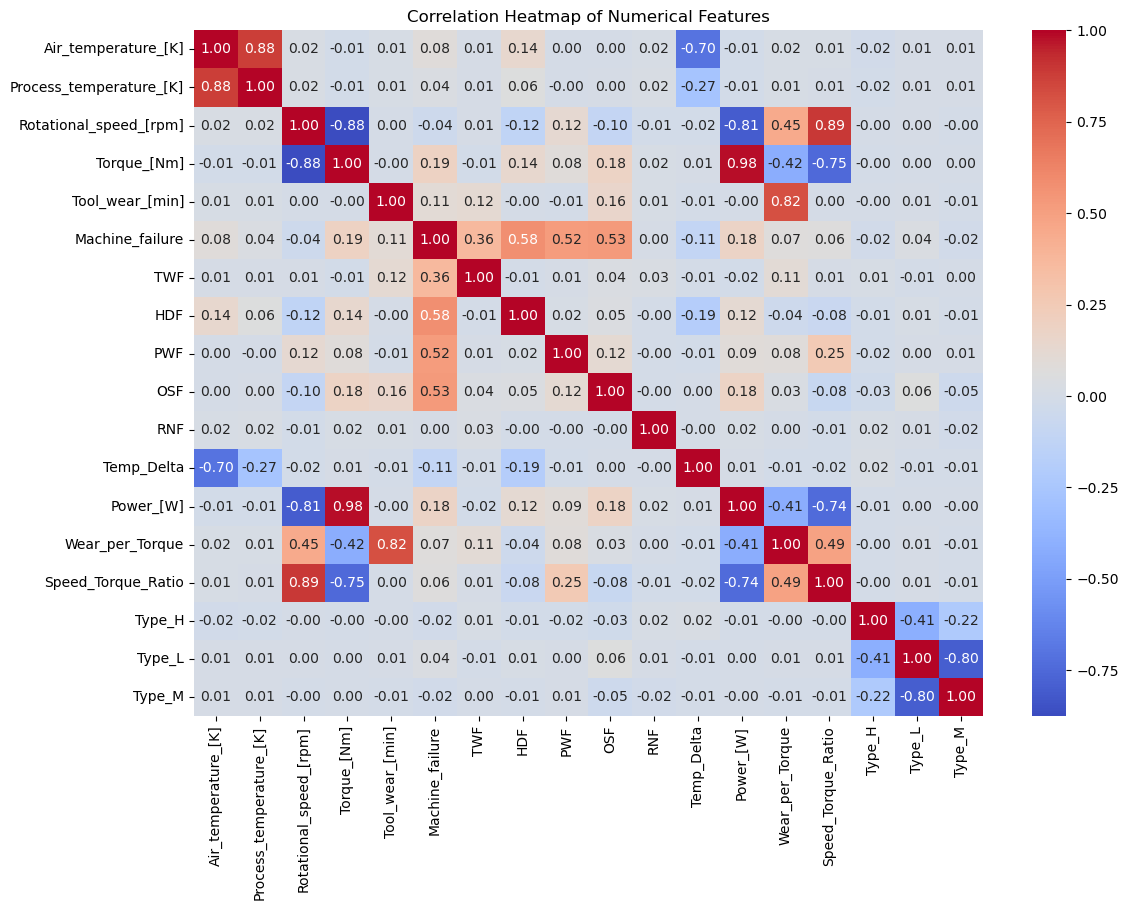

In [15]:
# === Select Numeric and Boolean Columns for Correlation Analysis ===
# Includes both continuous variables and one-hot encoded categorical features (boolean dtype)
numeric_df = df.select_dtypes(include=[np.number, 'bool'])

# === Correlation Heatmap ===
# Visualize pairwise Pearson correlations among numeric features to detect multicollinearity or patterns
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [16]:
# === Define Models for Training ===
# Logistic Regression as a baseline, Random Forest and XGBoost as ensemble methods
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [17]:
# === Prepare Data for Modeling ===

# Drop target and individual failure subtype columns to avoid data leakage during training
X = df.drop(columns=['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = df['Machine_failure']

# Normalize features to zero mean and unit variance for improved model convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Address class imbalance by applying SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split balanced data into training and test sets with stratified sampling to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.862     0.864     0.863      1933
           1      0.864     0.861     0.862      1932

    accuracy                          0.863      3865
   macro avg      0.863     0.863     0.863      3865
weighted avg      0.863     0.863     0.863      3865



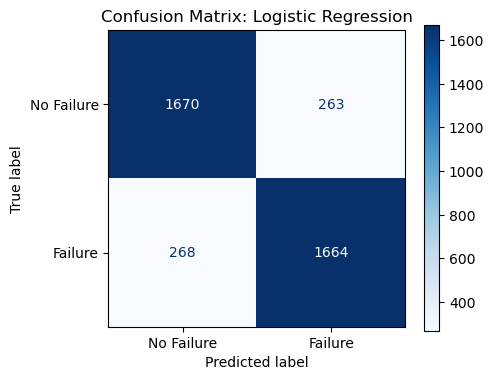


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.985     0.974     0.979      1933
           1      0.974     0.985     0.980      1932

    accuracy                          0.980      3865
   macro avg      0.980     0.980     0.980      3865
weighted avg      0.980     0.980     0.980      3865



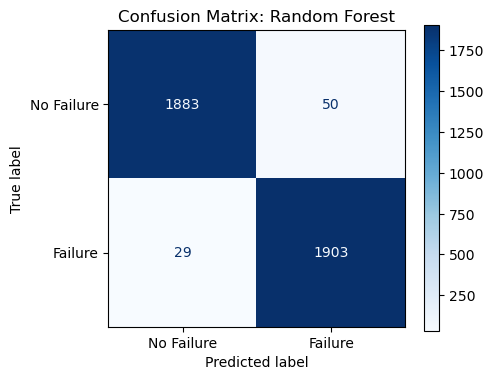


=== XGBoost ===
              precision    recall  f1-score   support

           0      0.992     0.980     0.986      1933
           1      0.980     0.992     0.986      1932

    accuracy                          0.986      3865
   macro avg      0.986     0.986     0.986      3865
weighted avg      0.986     0.986     0.986      3865



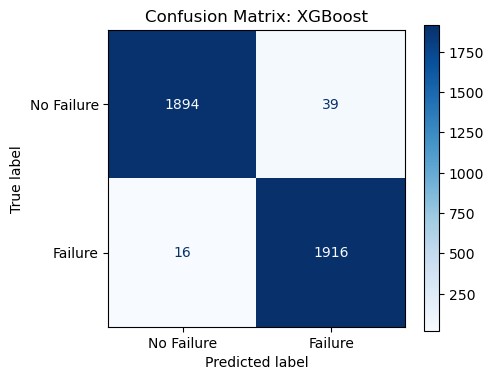

In [18]:
# === Train, Predict, and Evaluate Models ===
for name, model in models.items():
    model.fit(X_train, y_train)                     # Train model on training data
    y_pred = model.predict(X_test)                  # Predict on test data
    
    print(f"\n=== {name} ===")                       # Print model name for clarity
    print(classification_report(y_test, y_pred, digits=3))  # Detailed classification metrics
    
    cm = confusion_matrix(y_test, y_pred)           # Compute confusion matrix
    
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')  # Visualize confusion matrix
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()

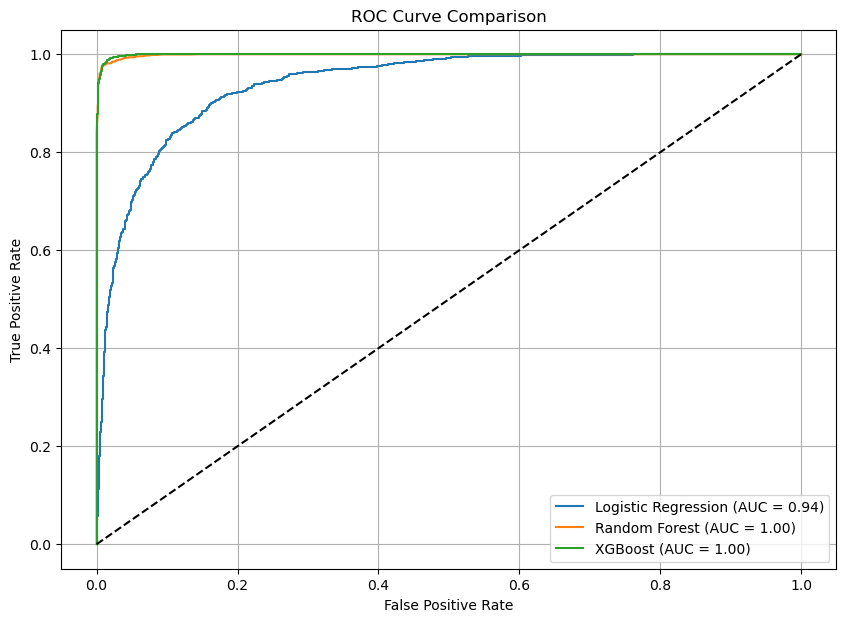

In [19]:
# === ROC Curve Comparison ===
# Compare discriminative ability of each model by plotting ROC curves and calculating AUC
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]    # Obtain predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)       # Compute false/true positive rates
    auc = roc_auc_score(y_test, y_proba)           # Calculate Area Under Curve (AUC)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')                    # Diagonal no-skill line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

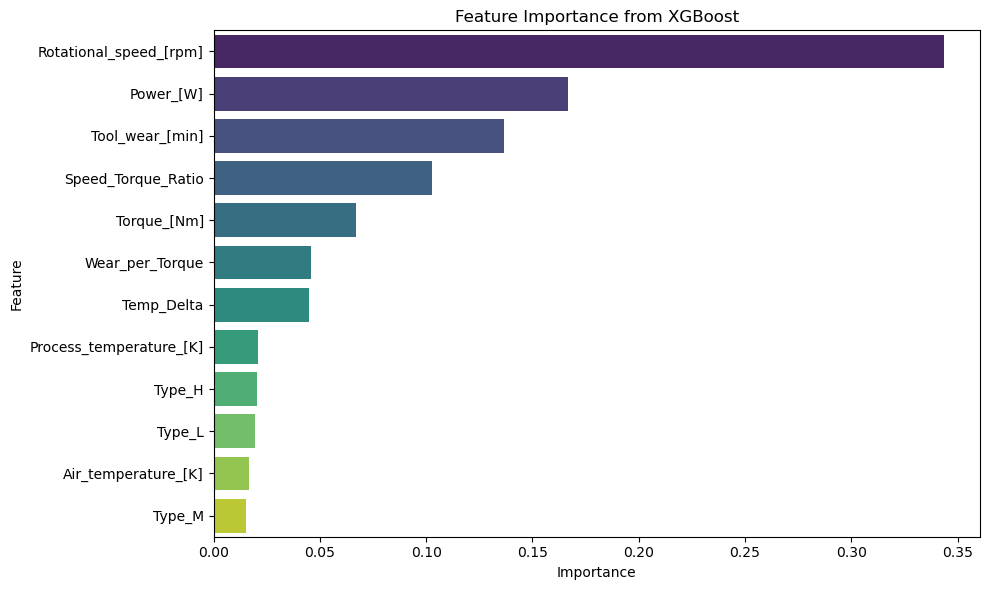

In [20]:
# === Feature Importance from Best Model (XGBoost) ===
best_model = models["XGBoost"]                      # Select the best-performing model

importances = best_model.feature_importances_       # Extract feature importance scores
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}) \
    .sort_values(by='Importance', ascending=False)  # Sort features by importance

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')  # Plot feature importances
plt.title('Feature Importance from XGBoost')
plt.tight_layout()
plt.show()

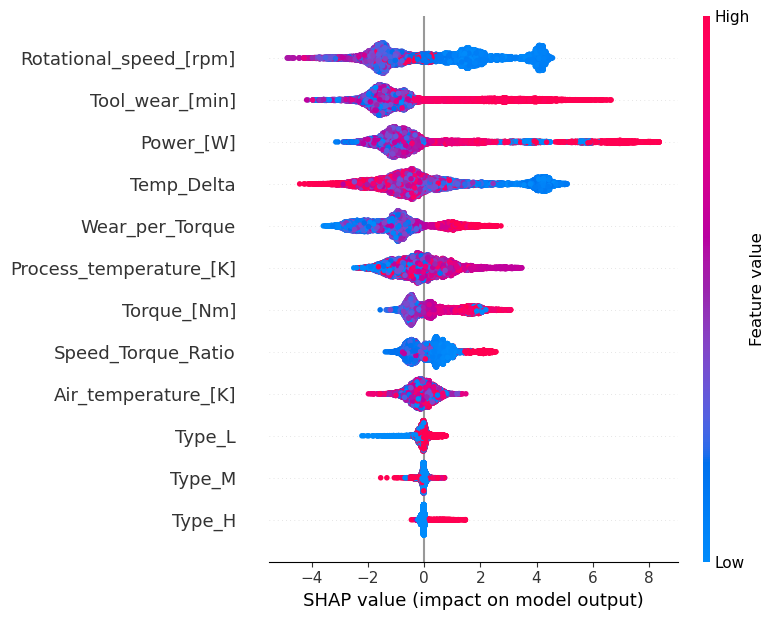

In [21]:
# === SHAP Explainability for Best Model ===
explainer = shap.TreeExplainer(best_model)          # Initialize SHAP explainer for tree-based model
shap_values = explainer.shap_values(X_train)        # Calculate SHAP values on training data

# Plot SHAP summary plot for global feature impact
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_train, feature_names=X.columns)
else:
    shap.summary_plot(shap_values, X_train, feature_names=X.columns)

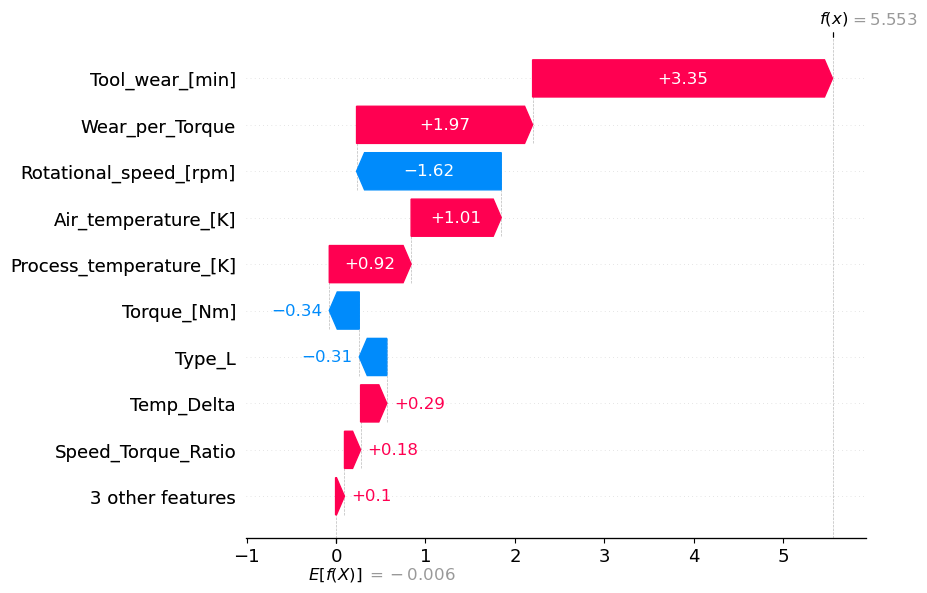

In [22]:
# === SHAP Waterfall Plot for a Single Failure Prediction ===
# Select first failure instance index from test set for explanation
fail_pos = np.where(y_test.values == 1)[0][0]

# Convert X_test back to DataFrame for easier handling
X_test = pd.DataFrame(X_test, columns=X.columns)
x_fail = X_test.iloc[fail_pos]

shap.initjs()   # Initialize JS visualization in notebook

# Generate SHAP waterfall plot to explain the contribution of each feature for the selected instance
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[1][fail_pos] if isinstance(shap_values, list) else shap_values[fail_pos],
    feature_names=X.columns
)

In [23]:
import joblib

# Choose your deployment model here
deployed_model = models["XGBoost"]     # or: "Random Forest", "Logistic Regression"

# Save the trained model
joblib.dump(deployed_model, "model.pkl")

# Save the trained scaler
joblib.dump(scaler, "scaler.pkl")

# Save the feature names (important!)
joblib.dump(X.columns.tolist(), "feature_names.pkl")

print("Model, scaler, and feature names saved.")


Model, scaler, and feature names saved.


In [46]:
import os

print("Model saved at:", os.path.abspath("model.pkl"))
print("Scaler saved at:", os.path.abspath("scaler.pkl"))
print("Feature names saved at:", os.path.abspath("feature_names.pkl"))

Model saved at: /Users/nandiniamaresh/model.pkl
Scaler saved at: /Users/nandiniamaresh/scaler.pkl
Feature names saved at: /Users/nandiniamaresh/feature_names.pkl
